# Data 102 Final Project Code

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
dem_df = pd.read_csv("Data/dem_candidates.csv")

In [7]:
dem_df.iloc[40:50]

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
40,David Peterson,CA,U.S. House California District 1,Representative,Regular,6/5/18,Lost,NaN,NaN,-21.379999,...,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN
41,Jessica Holcombe,CA,U.S. House California District 1,Representative,Regular,6/5/18,Lost,NaN,NaN,-21.379999,...,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN
42,Marty Walters,CA,U.S. House California District 1,Representative,Regular,6/5/18,Lost,NaN,NaN,-21.379999,...,NaN,NaN,NaN,No,No,NaN,Yes,NaN,NaN,NaN
43,Dotty Nygard,CA,U.S. House California District 10,Representative,Regular,6/5/18,Lost,NaN,NaN,0.620000,...,NaN,NaN,NaN,Yes,Yes,NaN,No,NaN,NaN,NaN
44,Josh Harder,CA,U.S. House California District 10,Representative,Regular,6/5/18,Advanced,NaN,On the Ballot,0.620000,...,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN
45,Michael Eggman,CA,U.S. House California District 10,Representative,Regular,6/5/18,Lost,NaN,NaN,0.620000,...,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN
46,Mike Barkley,CA,U.S. House California District 10,Representative,Regular,6/5/18,Lost,NaN,NaN,0.620000,...,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN
47,Sue Zwahlen,CA,U.S. House California District 10,Representative,Regular,6/5/18,Lost,NaN,NaN,0.620000,...,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN
48,Virginia Madueno,CA,U.S. House California District 10,Representative,Regular,6/5/18,Lost,NaN,NaN,0.620000,...,NaN,NaN,NaN,No,No,NaN,Yes,NaN,NaN,NaN
49,TJ Cox,CA,U.S. House California District 21,Representative,Regular,6/5/18,Advanced,NaN,On the Ballot,11.870000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

### EDA for Causal Inference

Our research question for this section is: "Does having the support of the Democratic Party have a causal relationship with winning the primary?" To explore this question, we will visualize the relationship between two categorical variables, "Won Primary" and "Party Support" in the Democrat dataset, which are the outcome and treatment respectively.

In [8]:
def win_loss_bar(col):
    causal_inf_df = dem_df[["Won Primary", col]]
    causal_inf_df = causal_inf_df.dropna()
    cross_tabulation = pd.crosstab(index=causal_inf_df['Won Primary'], columns=causal_inf_df[col])
    cross_tabulation.plot.bar()

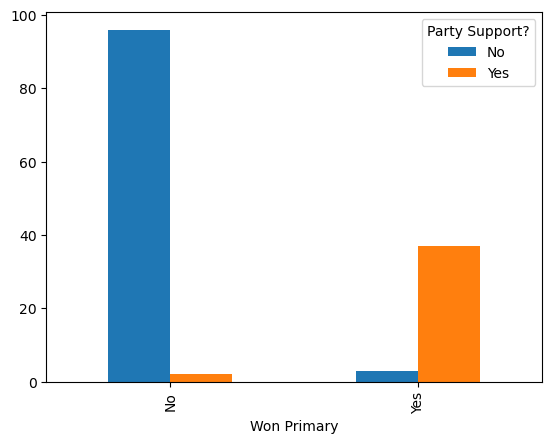

In [9]:
win_loss_bar('Party Support?')

Next, let's take a look to see if any other factors seem to be distributed differently between candidates that won or lost the primary, to identify protential confounders and colliders.

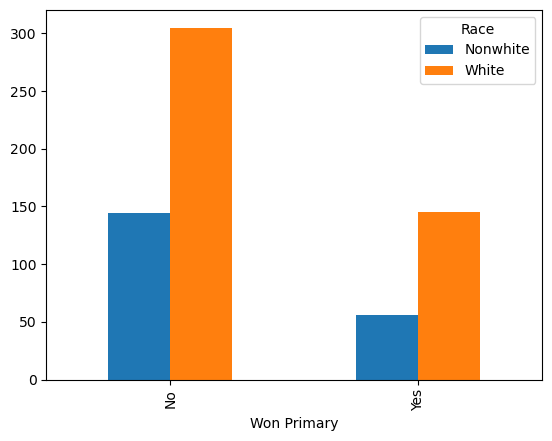

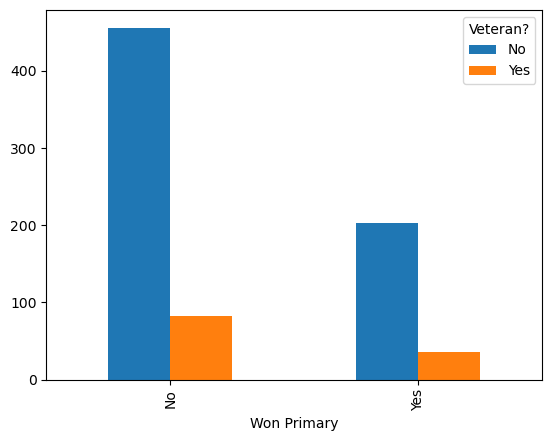

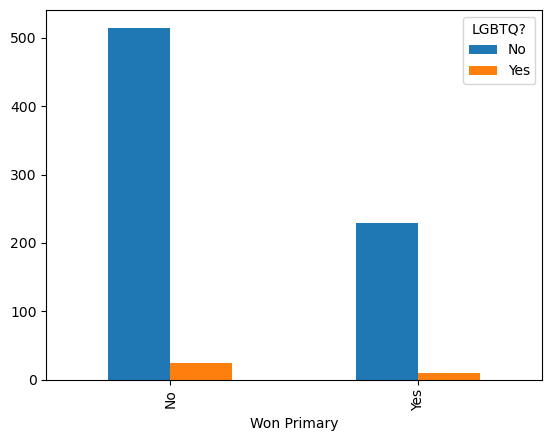

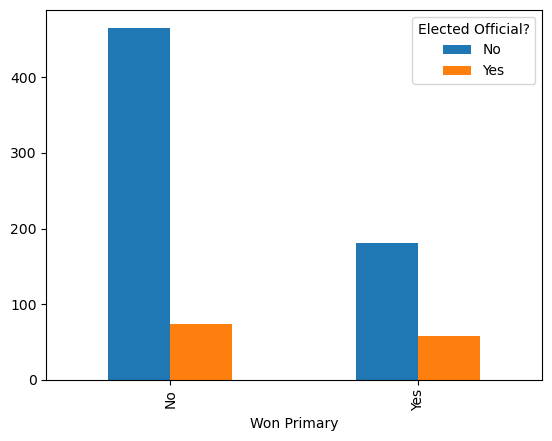

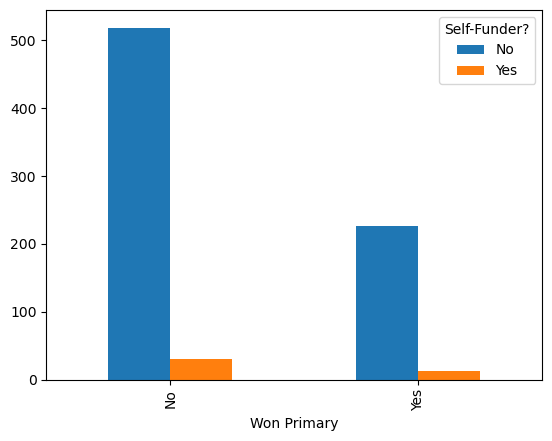

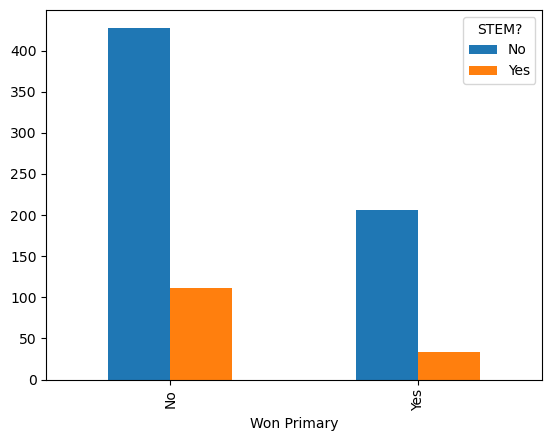

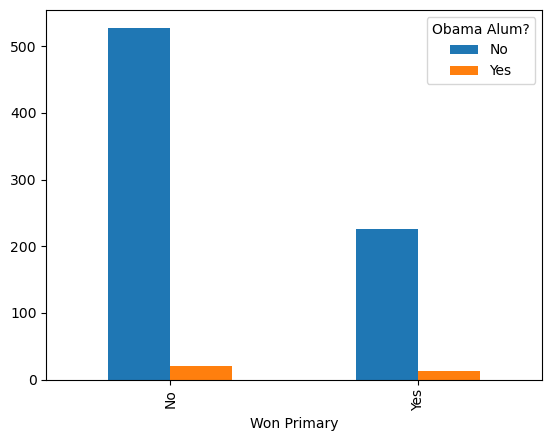

In [10]:
for i in ['Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?']:
    win_loss_bar(i)

#### Summary
We observe a few trends from these visualizations. 
1. The majority of candidates who win the primary have the support of their party
2. The majority of candidates who did not win the primary did not have the support of their party.
3. Other variables about the candidate, such as `Race`, `Veteran?`, `LGBTQ?`, and `Elected Official?` may also influence the primary results, and may therefore act as confounders in our research question.

The visualization is relevant to our research question as it suggests that the causal relationship does exist. It motivates us to investigate this research question farther.

#### Data Cleaning
In cleaning the data, we dropped the candidates who participated in races where the Democratic Party did not endorse anybody. This amounts to dropping rows that have "NaN" values for Party Support. We believe that not having the endorsement when no one else does is a different sort of treatment than not having the endorsement when someone else does. Thus, we choose to the exclude those observations.

If we had included those rows, the visualization would lead us to believe the opposite conclusion. This is because the party only endorsed candidates for a minority of races (41/245). This means that an additional 204 candidates would be counted as winning the primary without Party Support. As such, the visualization would suggest that not having Party Support is advantageous to winning the primary. We demonstrate these claims in the cells below.

<Axes: xlabel='Won Primary'>

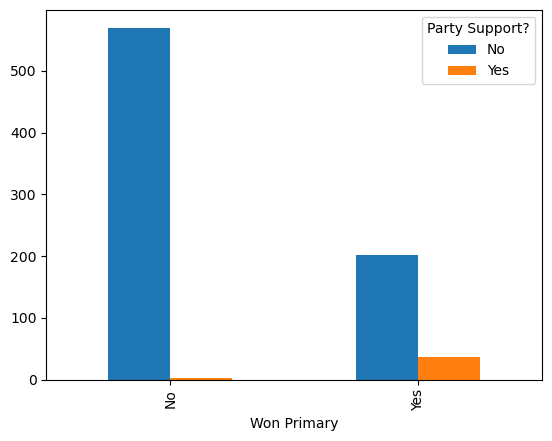

In [11]:
causal_inf_df = dem_df[["Won Primary", "Party Support?"]]
causal_inf_df = causal_inf_df.fillna("No")
cross_tabulation = pd.crosstab(index=causal_inf_df['Won Primary'], columns=causal_inf_df['Party Support?'])
cross_tabulation.plot.bar()

In [12]:
temp = dem_df[["Party Support?", "District"]]
temp = temp.replace({"Yes": "No"})
temp = temp.fillna("Yes")
temp = temp.rename(columns={"Party Support?": "Party Endorsed No One"})
temp.groupby(["Party Endorsed No One"])["District"].nunique()

Party Endorsed No One
No      41
Yes    204
Name: District, dtype: int64

### EDA for GLM and nonparametric methods

We want to create both GLM and a Nonparametric model to predict whether a candidate won or loss their primary election. In order to build our models, we must find some features that are associated with receiving/not receiving votes in the primary election.

First we checked to see if the Partisan Lean of the district or state of the election has any relationship with whether or not the Democrat was able to win.

According to FiveThirtyEight, Partisan Lean is calculated as the following: "Partisan leans are calculated by finding the average difference between how a state or district voted in the past two presidential elections and how the country voted overall, with 2016 results weighted 75 percent and 2012 results weighted 25 percent."

/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='Partisan Lean', ylabel='Density'>

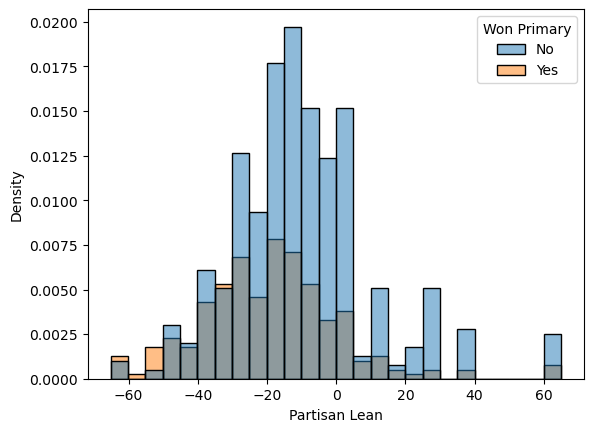

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data = dem_df, x="Partisan Lean", hue="Won Primary", stat="density")

In [15]:
dem_df_won_primary = dem_df[dem_df['Won Primary'] == 'Yes']
dem_df_lost_primary = dem_df[dem_df['Won Primary'] == 'No']

dem_df_won_primary['Partisan Lean'].describe()

count    239.000000
mean     -19.126360
std       20.377721
min      -65.209999
25%      -32.269998
50%      -18.959999
75%       -8.335000
max       65.089996
Name: Partisan Lean, dtype: float64

In [16]:
dem_df_lost_primary['Partisan Lean'].describe()

count    550.000000
mean     -10.450345
std       20.540671
min      -62.480000
25%      -21.680000
50%      -13.230000
75%       -0.405000
max       65.089996
Name: Partisan Lean, dtype: float64

Based on the histogram that we produced, we can see a slight difference in distributions in terms of partisan lean between candidates who won the primary, and candidates who didn't. The average partisan lean of the candidates who won the primary (-19.126) was far more negative than than the average of those who did not win (-10.450). Overall, we can also see that the former distribution lies slightly to the left (or in other words further the negative direction in terms of partisan lean) compared to the later, as observed by the 25th and 75th quartiles both being lower.

Next, we checked to see how the distribution of % of votes received by candidates changed depending on various categorical features. We looked to see if there was a change in the distribution depending on 

- whether the candidate received the Gun Sense Candidate Distinction from Moms Demand Action/Everytown for Gun Safety before the primary

- whether they were White vs Nonwhite,

- whether they held an elected position before.

- and whether they were endorsed by Biden.

/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='Primary %', ylabel='Density'>

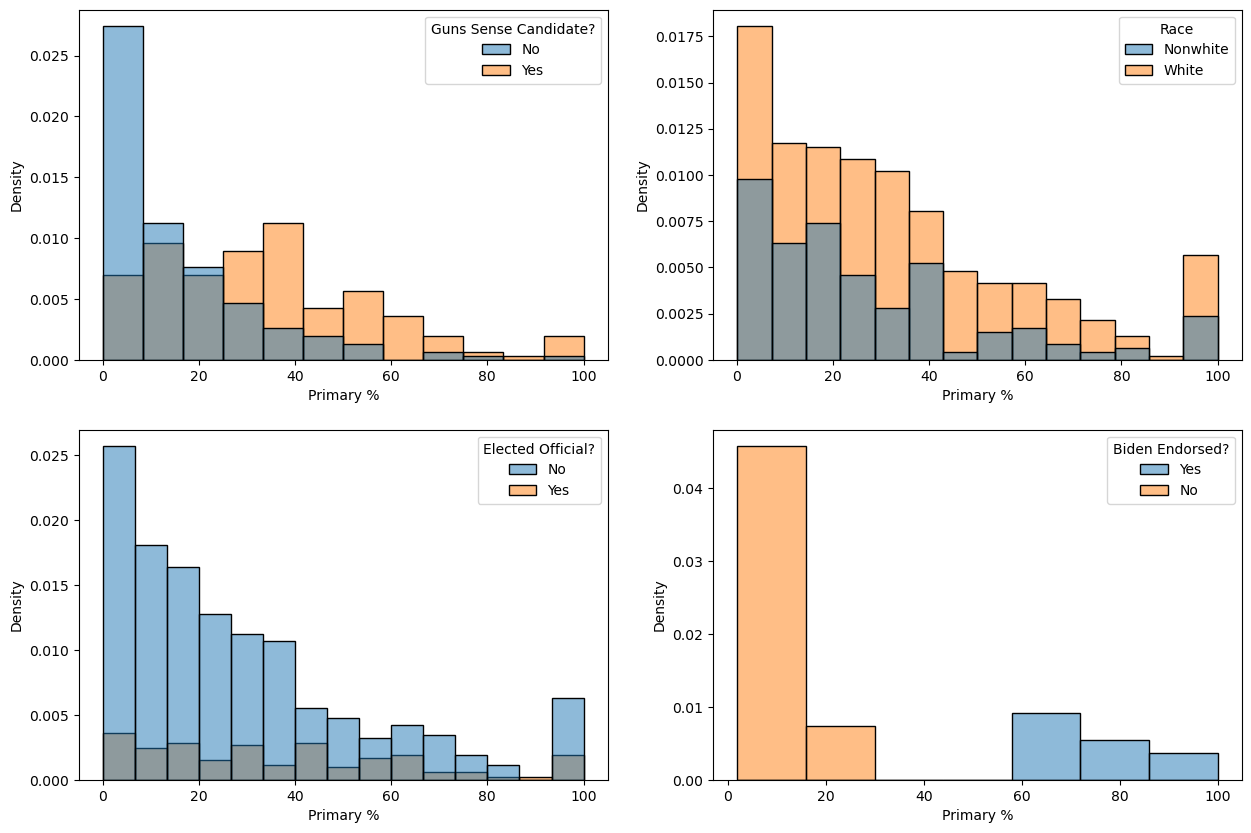

In [17]:
fig, axs = plt.subplots(2,2,  figsize=(15, 10))

sns.histplot(data = dem_df, x="Primary %", hue="Guns Sense Candidate?", stat="density",  ax=axs[0, 0])
sns.histplot(data = dem_df, x="Primary %", hue="Race", stat="density",  ax=axs[0, 1])
sns.histplot(data = dem_df, x="Primary %", hue="Elected Official?", stat="density", ax=axs[1,0])
sns.histplot(data = dem_df, x="Primary %", hue="Biden Endorsed?", stat="density", ax=axs[1,1])


Examining the four categorical features we explored:

- Gun Sense Candidate: the distribution gun sense candidates has a less dramatic tail and higher mean in terms of the % votes that they received compared to non-gun sense candidates

- Race: there does not seem to be a significant difference in the distributions of nonwhite and white candidates other than the white candidate distribution having a higher density, due to there being more white candidates overall.

- Elected Official: while the distribution of non-Elected official has a dramatic tail to the right, with most candidates obtaining a low % of votes, the distribution for Elected officials is more uniform in comparison.

- Biden Endorsed: there is a clear difference in distributions when we split candidates by this feature, as all Biden Endorsed candidates received a higher % votes compared to any of the non-Biden Endorsed candidates.

## Prediction with GLMs and Nonparametric Methods

### Feature Engineering + Selection

In [18]:
#drops rows with all null values, drops unnecessary columns, converts target column to boolean
final_df = dem_df[~dem_df['Veteran?'].isnull()]
final_df['y'] = (final_df['Primary Status'] == 'Advanced').astype(int)

final_df = final_df.iloc[:,9:]

final_df = final_df.drop(columns=['No Labels Support?', 'Won Primary', 'Primary %'])

#converts boolean columns to 0 and 1
if 'Yes' in list(final_df['Veteran?']):
    for i in ['Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?']:
        final_df[i] = (final_df[i] == 'Yes').astype(int)

# One-hot encoding
def one_hot_encode(df, col_names):
    final_df = df
    for c in col_names:
        ohe_df = pd.get_dummies(final_df[c])
        ohe_df = ohe_df.rename(columns={'Yes': c[:-1] + '_Yes', 'No': c[:-1] + '_No'})
        final_df = pd.concat([final_df, ohe_df], axis=1).drop(columns=[c])
    return final_df

final_df = one_hot_encode(final_df, list(final_df.columns)[8:-1])


# One-hot encoding race
def one_hot_encode_race(df, col_names):
    final_df = df
    for c in col_names:
        ohe_df = pd.get_dummies(final_df[c])
        ohe_df = ohe_df.rename(columns={'White': c + '_White', 'Nonwhite': c + '_Nonwhite'})
        final_df = pd.concat([final_df, ohe_df], axis=1).drop(columns=[c])
    return final_df

final_df = one_hot_encode_race(final_df, ['Race'])

/var/folders/gw/0n15bsmd0nb96584y3lyd06r0000gn/T/ipykernel_58430/715598047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['y'] = (final_df['Primary Status'] == 'Advanced').astype(int)


In [19]:
final_df.head()

,Partisan Lean,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,y,Party Support_No,Party Support_Yes,...,PCCC Endorsed_No,PCCC Endorsed_Yes,Indivisible Endorsed_No,Indivisible Endorsed_Yes,WFP Endorsed_No,WFP Endorsed_Yes,VoteVets Endorsed_No,VoteVets Endorsed_Yes,Race_Nonwhite,Race_White
0,-28.879999,1,0,0,0,0,0,0,False,False,...,False,False,False,False,False,False,False,False,True,False
1,-28.879999,0,1,0,0,0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
2,-28.879999,1,0,0,0,0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
3,-28.879999,1,0,1,0,0,0,0,False,False,...,False,False,False,False,False,False,False,False,True,False
4,-28.879999,0,0,1,0,0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True


### Nonparametric Modeling

In [20]:
## Fit a Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [21]:
train, test = train_test_split(final_df, test_size = 0.2, random_state = 42)

In [22]:
final_df.columns

Index(['Partisan Lean', 'Veteran?', 'LGBTQ?', 'Elected Official?',
       'Self-Funder?', 'STEM?', 'Obama Alum?', 'y', 'Party Support_No',
       'Party Support_Yes', 'Emily Endorsed_No', 'Emily Endorsed_Yes',
       'Guns Sense Candidate_No', 'Guns Sense Candidate_Yes',
       'Biden Endorsed_No', 'Biden Endorsed_Yes', 'Warren Endorsed?_No',
       'Warren Endorsed?_Yes', 'Sanders Endorsed_No', 'Sanders Endorsed_Yes',
       'Our Revolution Endorsed_No', 'Our Revolution Endorsed_Yes',
       'Justice Dems Endorsed_No', 'Justice Dems Endorsed_Yes',
       'PCCC Endorsed_No', 'PCCC Endorsed_Yes', 'Indivisible Endorsed_No',
       'Indivisible Endorsed_Yes', 'WFP Endorsed_No', 'WFP Endorsed_Yes',
       'VoteVets Endorsed_No', 'VoteVets Endorsed_Yes', 'Race_Nonwhite',
       'Race_White'],
      dtype='object')

In [23]:
rf_features = ['Partisan Lean', 'Veteran?', 'LGBTQ?', 'Elected Official?',
       'Self-Funder?', 'STEM?', 'Obama Alum?', 'Party Support_No',
       'Party Support_Yes', 'Emily Endorsed_No', 'Emily Endorsed_Yes',
       'Guns Sense Candidate_No', 'Guns Sense Candidate_Yes',
       'Biden Endorsed_No', 'Biden Endorsed_Yes', 'Warren Endorsed?_No',
       'Warren Endorsed?_Yes', 'Sanders Endorsed_No', 
       'Our Revolution Endorsed_No', 'Our Revolution Endorsed_Yes',
       'Justice Dems Endorsed_No', 'Justice Dems Endorsed_Yes',
       'PCCC Endorsed_No', 'PCCC Endorsed_Yes', 'Indivisible Endorsed_No',
       'Indivisible Endorsed_Yes', 'WFP Endorsed_No', 'WFP Endorsed_Yes',
       'VoteVets Endorsed_No', 'VoteVets Endorsed_Yes', 'Race_Nonwhite',
       'Race_White']

In [24]:
np.random.seed(69)
X_train = train[rf_features]
X_test = test[rf_features]

y_train = train['y']
y_test = test['y']

rf = RandomForestClassifier(max_depth = 8)

rf.fit(X_train, y_train)
print(np.mean(rf.predict(X_train) == y_train))
print(np.mean(rf.predict(X_test) == y_test))

0.809375
0.79375


/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_

In [25]:
rf_importance = pd.DataFrame({'feature' : rf_features, 'importance' : rf.feature_importances_})
rf_importance.sort_values('importance')

,feature,importance
15,Warren Endorsed?_No,0.004712
17,Sanders Endorsed_No,0.006298
23,PCCC Endorsed_Yes,0.006598
13,Biden Endorsed_No,0.007017
2,LGBTQ?,0.008108
16,Warren Endorsed?_Yes,0.008298
6,Obama Alum?,0.009600
14,Biden Endorsed_Yes,0.011163
1,Veteran?,0.012307
21,Justice Dems Endorsed_Yes,0.012488


### Frequentist GLM Modeling

In [26]:
from sklearn.linear_model import LogisticRegression

frequentist_glm = LogisticRegression(random_state=0)

frequentist_glm.fit(X_train, y_train)
print(np.mean(frequentist_glm.predict(X_train) == y_train))
print(np.mean(frequentist_glm.predict(X_test) == y_test))

0.7984375
0.74375


/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/MarlonFu/opt/anaconda3/envs/data102/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_

### Bayesian GLM Modeling

In [ ]:
try:
    from pymc3 import *
    import pymc3 as pm
except:
    ! pip install pymc3
    from pymc3 import *
    import pymc3 as pm

In [23]:
glm_df = final_df
glm_df.columns = [n.replace('?', '') for n in list(glm_df.columns)]
glm_df.columns = [n.replace(' ', '_') for n in list(glm_df.columns)]
glm_df.columns = [n.replace('-', '_') for n in list(glm_df.columns)]
glm_df.columns

Index(['Partisan_Lean', 'Veteran', 'LGBTQ', 'Elected_Official', 'Self_Funder',
       'STEM', 'Obama_Alum', 'y', 'Party_Support_No', 'Party_Support_Yes',
       'Emily_Endorsed_No', 'Emily_Endorsed_Yes', 'Guns_Sense_Candidate_No',
       'Guns_Sense_Candidate_Yes', 'Biden_Endorsed_No', 'Biden_Endorsed_Yes',
       'Warren_Endorsed_No', 'Warren_Endorsed_Yes', 'Sanders_Endorsed_No',
       'Sanders_Endorsed_Yes', 'Our_Revolution_Endorsed_No',
       'Our_Revolution_Endorsed_Yes', 'Justice_Dems_Endorsed_No',
       'Justice_Dems_Endorsed_Yes', 'PCCC_Endorsed_No', 'PCCC_Endorsed_Yes',
       'Indivisible_Endorsed_No', 'Indivisible_Endorsed_Yes',
       'WFP_Endorsed_No', 'WFP_Endorsed_Yes', 'VoteVets_Endorsed_No',
       'VoteVets_Endorsed_Yes', 'Race_Nonwhite', 'Race_White'],
      dtype='object')

In [24]:
delim = ' + '
temp_lst = glm_df.columns.to_list()
temp_lst.remove('y')
result = delim.join(list(map(str, temp_lst)))
result

'Partisan_Lean + Veteran + LGBTQ + Elected_Official + Self_Funder + STEM + Obama_Alum + Party_Support_No + Party_Support_Yes + Emily_Endorsed_No + Emily_Endorsed_Yes + Guns_Sense_Candidate_No + Guns_Sense_Candidate_Yes + Biden_Endorsed_No + Biden_Endorsed_Yes + Warren_Endorsed_No + Warren_Endorsed_Yes + Sanders_Endorsed_No + Sanders_Endorsed_Yes + Our_Revolution_Endorsed_No + Our_Revolution_Endorsed_Yes + Justice_Dems_Endorsed_No + Justice_Dems_Endorsed_Yes + PCCC_Endorsed_No + PCCC_Endorsed_Yes + Indivisible_Endorsed_No + Indivisible_Endorsed_Yes + WFP_Endorsed_No + WFP_Endorsed_Yes + VoteVets_Endorsed_No + VoteVets_Endorsed_Yes + Race_Nonwhite + Race_White'

In [25]:
formula = 'y ~ Partisan_Lean + Veteran + LGBTQ + Elected_Official + Self_Funder + STEM + Obama_Alum + Party_Support_No + Party_Support_Yes + Emily_Endorsed_No + Emily_Endorsed_Yes + Guns_Sense_Candidate_No + Guns_Sense_Candidate_Yes + Biden_Endorsed_No + Biden_Endorsed_Yes + Warren_Endorsed_No + Warren_Endorsed_Yes + Sanders_Endorsed_No + Sanders_Endorsed_Yes + Our_Revolution_Endorsed_No + Our_Revolution_Endorsed_Yes + Justice_Dems_Endorsed_No + Justice_Dems_Endorsed_Yes + PCCC_Endorsed_No + PCCC_Endorsed_Yes + Indivisible_Endorsed_No + Indivisible_Endorsed_Yes + WFP_Endorsed_No + WFP_Endorsed_Yes + VoteVets_Endorsed_No + VoteVets_Endorsed_Yes + Race_Nonwhite + Race_White'

with pm.Model() as bayesian_GLM:
    pm.glm.GLM.from_formula(formula, final_df, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, cores=2, init='adapt_diag')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Race_White, Race_Nonwhite, VoteVets_Endorsed_Yes, VoteVets_Endorsed_No, WFP_Endorsed_Yes, WFP_Endorsed_No, Indivisible_Endorsed_Yes, Indivisible_Endorsed_No, PCCC_Endorsed_Yes, PCCC_Endorsed_No, Justice_Dems_Endorsed_Yes, Justice_Dems_Endorsed_No, Our_Revolution_Endorsed_Yes, Our_Revolution_Endorsed_No, Sanders_Endorsed_Yes, Sanders_Endorsed_No, Warren_Endorsed_Yes, Warren_Endorsed_No, Biden_Endorsed_Yes, Biden_Endorsed_No

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 455 seconds.
There were 990 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.892066100709781, but should be close to 0.8. Try to increase the number of tuning steps.
There were 996 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (34), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'Partisan_Lean'}>,
        <AxesSubplot: title={'center': 'Partisan_Lean'}>],
       [<AxesSubplot: title={'center': 'Veteran'}>,
        <AxesSubplot: title={'center': 'Veteran'}>],
       [<AxesSubplot: title={'center': 'LGBTQ'}>,
        <AxesSubplot: title={'center': 'LGBTQ'}>],
       [<AxesSubplot: title={'center': 'Elected_Official'}>,
        <AxesSubplot: title={'center': 'Elected_Official'}>],
       [<AxesSubplot: title={'center': 'Self_Funder'}>,
        <AxesSubplot: title={'center': 'Self_Funder'}>],
       [<AxesSubplot: title={'center': 'STEM'}>,
        <AxesSubplot: title={'center': 'STEM'}>],
       [<AxesSubplot: title={'center': 'Obama_Alum'}>,
        <AxesSubplot: title={'center': 'Obama_Alum'}>],
       [<AxesSubplot: title={'center': 'Party_Support_No'}>,
        <AxesSubplot: title={'center': 'Party_Support_No'}>],

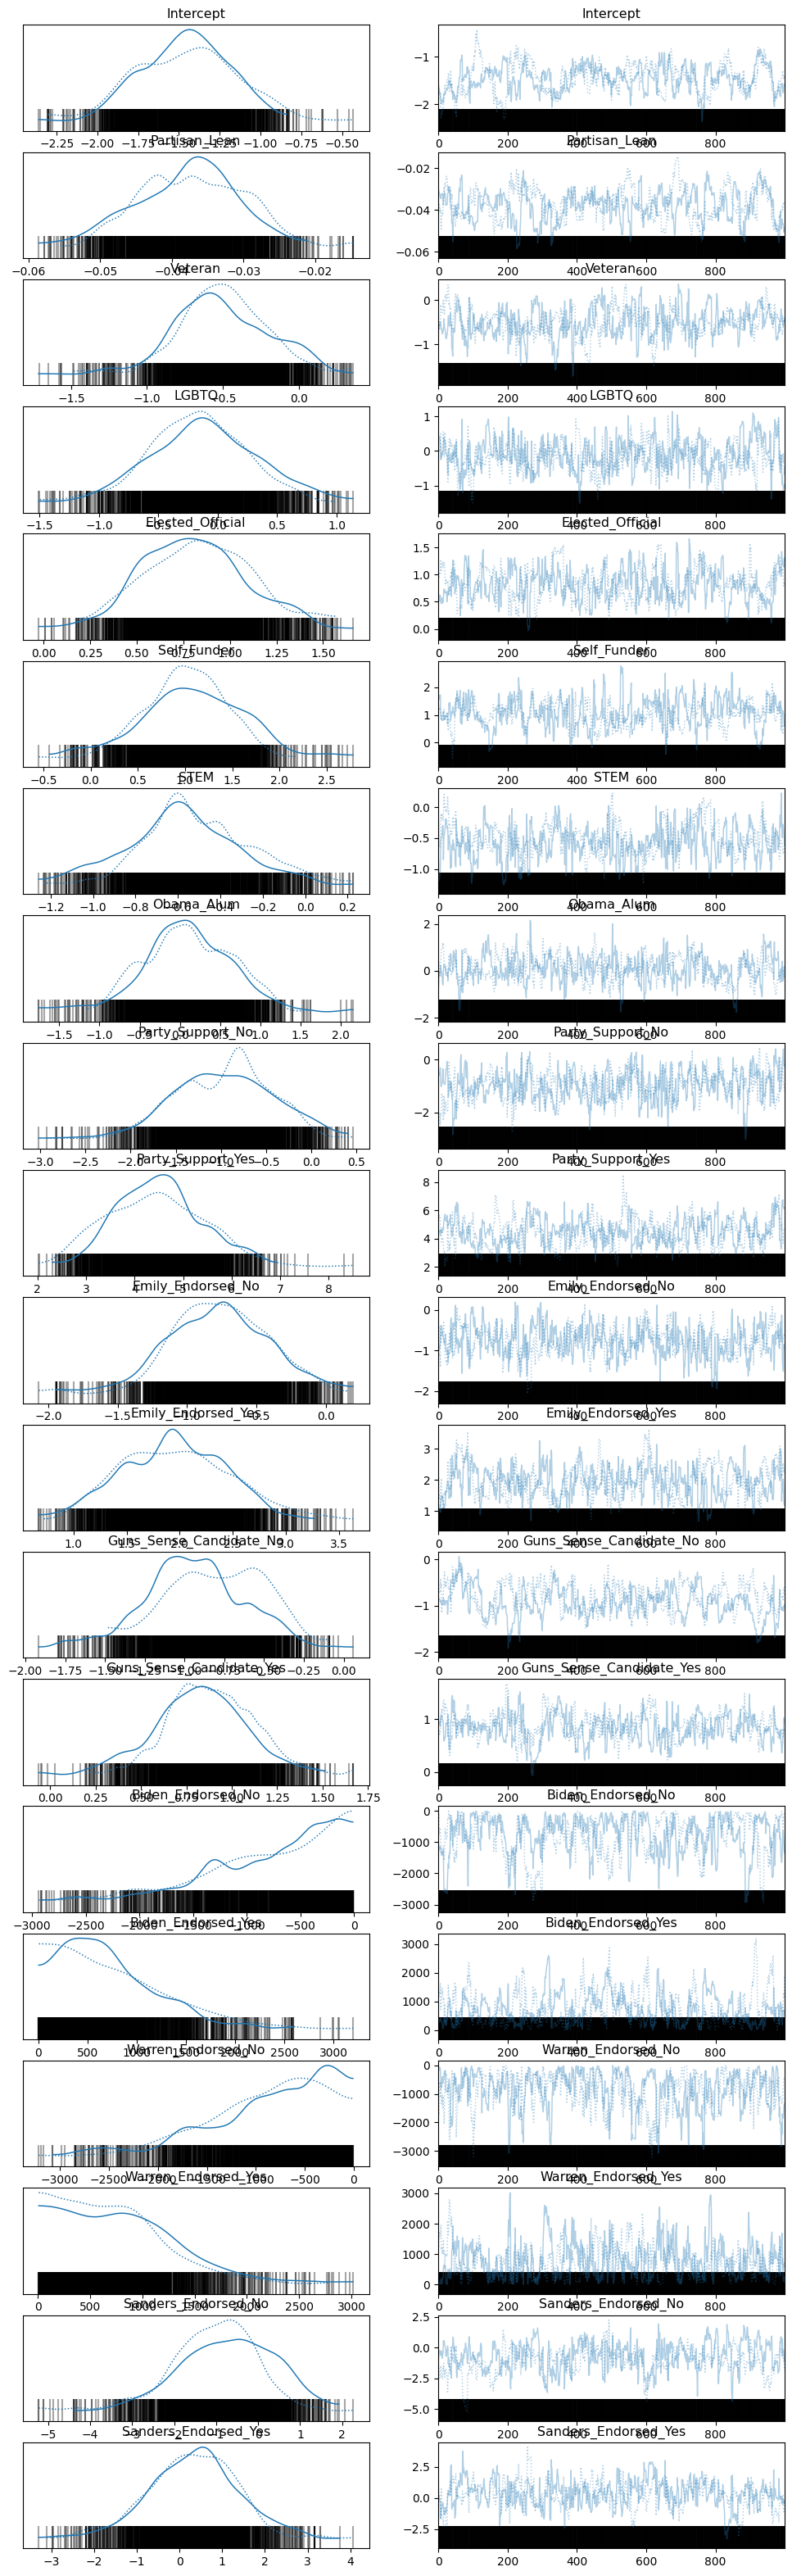

In [30]:
plot_trace(trace)

In [31]:
pm.summary(trace).round(2)

Got error No model on context stack. trying to find log_likelihood in translation.
/root/venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.46,0.29,-1.97,-0.94,0.03,0.02,89.0,165.0,1.02
Partisan_Lean,-0.04,0.01,-0.05,-0.02,0.00,0.00,102.0,203.0,1.01
Veteran,-0.51,0.32,-1.03,0.12,0.03,0.02,135.0,236.0,1.01
LGBTQ,-0.14,0.44,-0.93,0.74,0.03,0.02,164.0,262.0,1.01
Elected_Official,0.82,0.29,0.35,1.43,0.02,0.02,158.0,142.0,1.01
Self_Funder,1.05,0.48,0.15,1.90,0.04,0.03,145.0,250.0,1.02
STEM,-0.54,0.26,-1.03,-0.01,0.03,0.02,87.0,158.0,1.02
Obama_Alum,0.10,0.55,-0.84,1.11,0.04,0.03,150.0,332.0,1.01
Party_Support_No,-0.97,0.55,-1.92,0.06,0.04,0.03,230.0,312.0,1.02
Party_Support_Yes,4.48,0.94,2.78,6.28,0.08,0.05,156.0,209.0,1.01


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score

with bayesian_GLM:
    ppc = pm.sample_posterior_predictive(trace, samples=500)
    
with bayesian_GLM:
    scores = np.mean(ppc['y'], axis=0)

predictions = [1 if s > 0.5 else 0 for s in scores]

conf_mat = confusion_matrix(final_df['y'], predictions)
conf_mat

/root/venv/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[484,  51],
       [113, 152]])

In [29]:
glm_model_score = accuracy_score(final_df['y'], predictions)
print('The Accuracy for Bayesian GLM is:', glm_model_score)

The Accuracy for Bayesian GLM is: 0.795


## Causal Inference

Steps:

The unconfoundedness assumptions hold in this case because regardless of receiving Party Support, the possible outcomes for a candidate will always be (Win, Lose). Furthermore, being include in this More formally, what we are saying is that Z ⊥ [Y(0), Y(1)].

- Confounders:

- Partisan Lean

- Race

- Veteran?

- LGBTQ?

In [6]:
# Setup variables to conduct causal inference.
ipw_df = dem_df[~dem_df["Party Support?"].isna()]

z = ipw_df["Party Support?"].replace({"Yes": 1, "No": 0})

# Drop No Labels Support because it is NAN for everyone.
x = (ipw_df.iloc[:, 9:]
           .drop(columns=["Primary %", "Won Primary", "Party Support?", 'No Labels Support?'])
           .fillna(-1)
           .replace({"Yes": 1, "No": 0, "White": 1, "Nonwhite": 0}))

y = ipw_df["Won Primary"].replace({"Yes": 1, "No": 0})

## Asserting that confounders are confounders

In [7]:
x.columns.tolist()

['Partisan Lean',
 'Race',
 'Veteran?',
 'LGBTQ?',
 'Elected Official?',
 'Self-Funder?',
 'STEM?',
 'Obama Alum?',
 'Emily Endorsed?',
 'Guns Sense Candidate?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?']

In [8]:
eda_df = x.copy()
eda_df["Party Support"] = z
eda_df["Won Primary"] = y
corr_df = eda_df.corr().loc[ :, ["Party Support", "Won Primary"]]

In [8]:
def bootstrapping_corr_coef(df, feature, n):
    y_corrs = [None] * n
    z_corrs = [None] * n


    for i in range(n):
        sampled_df = df.sample(n=df.shape[0], replace=True)
        y_correlation = sampled_df[feature].corr(df["Won Primary"])
        z_correlation = sampled_df[feature].corr(df["Party Support"])

        y_corrs[i] = y_correlation
        z_corrs[i] = z_correlation
    return y_corrs, z_corrs

bootstrapped_corr_table = pd.DataFrame(columns=['feature', '0.025 y_corr', 'mean y_corr','0.975 y_corr',
                                                "0.025 z_corr", 'mean z_corr','0.975 z_corr'])
for feature in ['Partisan Lean',
 'Veteran?',
 'Elected Official?',

 'Emily Endorsed?',
 'Biden Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'VoteVets Endorsed?']:
    bootstrapped_coefs = bootstrapping_corr_coef(eda_df, feature, 100000)


    feature_corrs = pd.DataFrame({'feature': feature, 
                                                                '0.025 y_corr': round(np.percentile(np.array(bootstrapped_coefs[0]), 2.5), 3), 
                                                                'mean y_corr': round(np.mean(np.array(bootstrapped_coefs[0])), 3),
                                                                '0.975 y_corr': round(np.percentile(np.array(bootstrapped_coefs[0]), 97.5), 3), 
                                                                '0.025 z_corr': round(np.percentile(np.array(bootstrapped_coefs[1]), 2.5), 3), 
                                                                'mean z_corr': round(np.mean(np.array(bootstrapped_coefs[1])), 3), 
                                                                '0.975 z_corr': round(np.percentile(np.array(bootstrapped_coefs[1]), 97.5), 3)
                                                                 }, index=[0])

    bootstrapped_corr_table.reset_index(inplace=True, drop=True)
    feature_corrs.reset_index(inplace=True, drop=True)
    bootstrapped_corr_table= pd.concat([bootstrapped_corr_table, feature_corrs])
    
    


    


In [9]:
bootstrapped_corr_table

,feature,0.025 y_corr,mean y_corr,0.975 y_corr,0.025 z_corr,mean z_corr,0.975 z_corr
0,Partisan Lean,-0.348,-0.161,0.032,-0.311,-0.123,0.068
1,Veteran?,-0.074,0.100,0.278,-0.029,0.150,0.329
2,Elected Official?,0.078,0.266,0.444,0.134,0.324,0.498
3,Emily Endorsed?,-0.060,0.145,0.341,-0.016,0.192,0.388
4,Biden Endorsed?,-0.106,0.101,0.289,-0.099,0.110,0.300
5,Our Revolution Endorsed?,-0.255,-0.111,0.043,-0.259,-0.123,0.024
6,Justice Dems Endorsed?,-0.260,-0.124,0.027,-0.263,-0.139,-0.002
7,PCCC Endorsed?,-0.039,0.168,0.341,-0.086,0.105,0.288
0,VoteVets Endorsed?,-0.035,0.159,0.343,-0.003,0.194,0.377


Text(0.5, 1.0, 'Correlation Matrix for Potential Confounders')

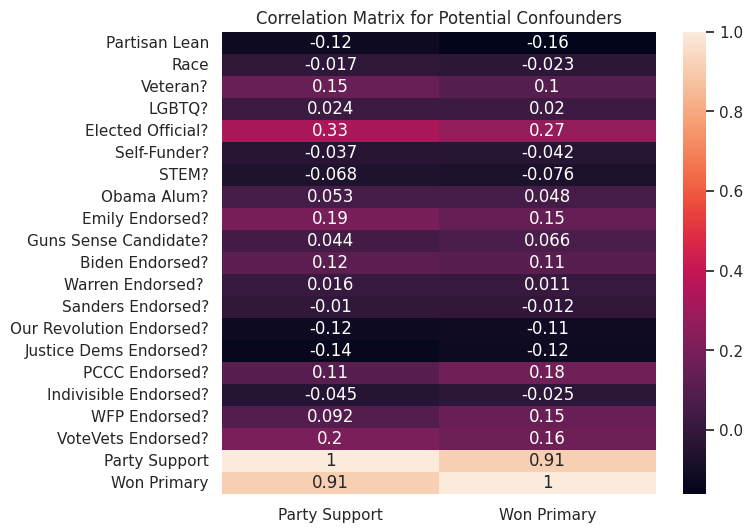

In [10]:
import seaborn as sns
sns.set(rc={'figure.figsize':(7,6)})
corr_matrix = sns.heatmap(corr_df, annot=True)
corr_matrix.set_title('Correlation Matrix for Potential Confounders')

In [32]:
x = x[["Partisan Lean", "Veteran?", "Elected Official?", "Emily Endorsed?", "Biden Endorsed?",
        "Our Revolution Endorsed?", "Justice Dems Endorsed?", "PCCC Endorsed?", "VoteVets Endorsed?"]]

pscore_rf = RandomForestClassifier(max_depth=3, n_estimators=500, random_state=69)
pscore_rf.fit(x,z)
pscore_rf.score(x, z)

0.9202898550724637

In [34]:
pscore_df = pd.DataFrame(pscore_rf.predict_proba(x), columns=["Predict_0", "Predict_1"])
pscore_df = pscore_df[(pscore_df["Predict_0"] < 0.9) | (pscore_df["Predict_0"] > 0.1)]

In [40]:
ate_df = pd.DataFrame(y)
ate_df["z"] = z
ate_df["pscore"] = pscore_df["Predict_1"]
ate_df

,Won Primary,z,pscore
19,1,1,0.115408
20,0,0,0.115408
21,0,0,0.131173
22,0,0,0.131173
43,0,0,0.483552
...,...,...,...
760,0,0,NaN
770,1,1,NaN
781,1,1,NaN
782,0,0,NaN


In [41]:
def get_ipw_ate(df):
    treatment_group = df[df["z"]==1]
    control_group = df[df["z"]==0]
    
    left = np.sum((treatment_group["Won Primary"]) / (treatment_group["pscore"])) / df.shape[0]
    right = np.sum((control_group["Won Primary"]) / (1-control_group["pscore"])) / df.shape[0]
    return left - right

get_ipw_ate(ate_df)

0.4511073192052542

In [42]:
def bootstrap_ate(df, n):

    storage_arr = [None] * n

    for i in range(n):
        sampled_df = df.sample(n=ate_df.shape[0], replace=True)
        sample_ate = get_ipw_ate(sampled_df)
        storage_arr[i] = sample_ate

    return(storage_arr)

bootstrapped_ates = bootstrap_ate(ate_df, 100000)

In [43]:
ci = np.quantile(a=np.array(bootstrapped_ates), q=[0.025, 0.975])
ci

array([0.1701784 , 0.78654172])

[Text(0.5, 0, 'Estimated ATE'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '100,000 bootstrapped ATE estimates')]

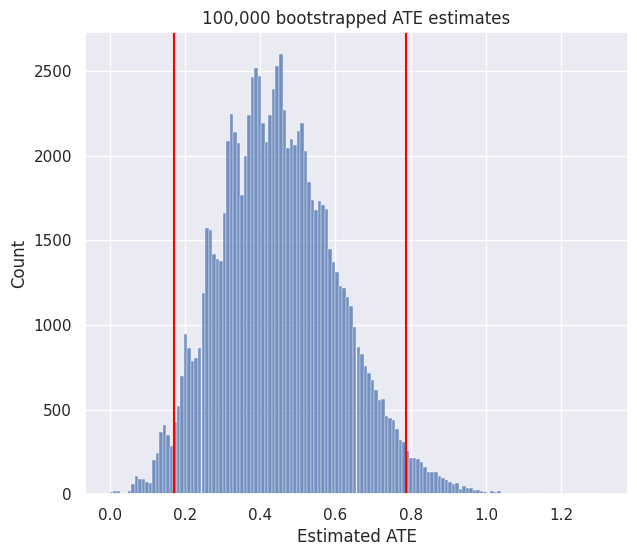

In [44]:
import seaborn as sns
ax1 = sns.histplot(data=bootstrapped_ates)

plt.axvline(ci[0], color="red")
plt.axvline(ci[1], color="red")
ax1.set(xlabel='Estimated ATE', ylabel='Count', title="100,000 bootstrapped ATE estimates")


Using Inverse Propensity Score Weighting to estimate the Average Treatment Effect of "Party Support" on Democrats winning their primary election - we arrived at an estimated ate of 0.429. This means that having Party Support increases your chances of winning the election by 42.9%. 